# Mask Detection with a Convoluted Neural Network

### Introduction

According to the CDC and other health authorities, cloth or medical masks are an effective method of reducing the spread of Covid-19. Many industries are using security guards or other staff members to enforce compliance of mask mandates but an automatic method would be much more efficient. Using still frames from video could be a method of alerting staff of an compliant visitor just like the magnetic detectors in retail stores alert staff when non purchased product is leaving the store. The goal of this project was to develop a model that is capable detecting whether someone is wearing a mask or not and therefore whether they are in compliance with health and safety regulations.

### Packages

The general python utility packages that were used for this project were: Numpy, Pandas, Time, and Matplotlib. The following packages were used to move and load file from the local directory: Glob, cv2, OS, Shutil, and Random. Finally, various Tensorflow and Keras packages were used for the neural network and its evaluation.

In [1]:
#Baseline utility packages
import numpy as np
import pandas as pd
import tensorflow as tf
from  matplotlib import pyplot as plt
import time
#File Moving Packages
import glob
import cv2
import os
import shutil
import random
#CNN packages
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Performance Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")

### Data

The input data for this project consisted of two datasets downloaded from Kaggle. These datasets are made up of .jpg images belonging to 2 classes, with a mask and without a mask. They can be found [here](https://www.kaggle.com/shanmukh05/mask-detection) and [here](https://www.kaggle.com/omkargurav/face-mask-dataset). Between these two datasets there are 5028 images without masks and 4913 images with masks. These images were then manually cleaned. Photos with the following characteristics were removed from the dateset: duplicates, pre-augmented images, collages, images with logos, and images with added text. The final image counts for each category are: 4465 without a mask and 4295 with a mask.

### Schema

For this project to run you must have the following schema and naming convention inplace within your working directory:

    -> yes   
    -> no   
    -> mask_detection_random   
        ---> no   
        ---> yes   
    -> test_rand   
        ---> no   
            ----> images   
        ---> yes   
            ----> images   
           
The original datasets should be deposited into the '/yes' and '/no' directories within the working directory based on their category of image. The '/yes' and '/no' directories are the directories where all the images are found prior to the randomized split. The '/mask_detection_random' directory is where the train and validation splits are saved while the '/test_rand' directory is where the test split is housed.

### Exploritory Data Analysis

Once the data was cleaned and the file structure implemented a simple exploratory data analysis was conducted. The shape of the train and validation datasets are checked to make sure the correct amount of files exist.

In [2]:
# reads in images from the '/yes' directory and appends them to an array, prints out the shape
yesData = []
yesFiles = glob.glob ("mask_detection_random/yes/*.jpg")
for fileName in yesFiles:
    image = cv2.imread(fileName)
    yesData.append(image)
                      
print(f"yesData shape = {np.array(yesData, dtype=object).shape[0]}")

# reads in images from the '/no' directory and appends them to an array, prints out the shape
noData = []
noFiles = glob.glob ("mask_detection_random/no/*.jpg")
for fileName in noFiles:
    image = cv2.imread(fileName)
    noData.append(image)
                      
print(f"noData shape = {np.array(noData, dtype=object).shape[0]}")

yesData shape = 4080
noData shape = 4241


The size of a small sample of images was then checked. As you can see they are not uniform and therefore will require resizing before they can be entered into the model.

In [3]:
#Grabs various images to check out the sizes
print(yesData[0].shape)
print(noData[1].shape)
print(yesData[2].shape)
print(noData[3].shape)
print(yesData[4].shape)

(933, 1400, 3)
(225, 225, 3)
(408, 612, 3)
(183, 275, 3)
(1000, 1500, 3)


To decide what standard size the model will intake the range of image heights and widths needs to be analyzed. The images have widths and heights ranging from 29 to 5760 pixels. 

In [4]:
# appends all the image heights and widths for each category
lenYes = np.arange(0,len(yesData))
lenNo = np.arange(0,len(noData))
height = []
width = []

for h in lenYes:
    height.append(yesData[h][0].shape)

for h in lenNo:
    height.append(noData[h][0].shape)
    
for h in lenYes:
    width.append(yesData[h][1].shape)

for h in lenNo:
    width.append(noData[h][1].shape)
    
# prints out the min and max heights and widths for each category    
print(f"The smallest height is : {min(height)}")
print(f"The smallest width is : {min(width)}")
print(f"The largest height is : {max(height)}")
print(f"The largest width is : {max(width)}")

The smallest height is : (29, 3)
The smallest width is : (29, 3)
The largest height is : (5760, 3)
The largest width is : (5760, 3)


### Functions

The end goal of this project is to run multiple iterations of the model with different randomized splits of data. For that to be efficiently written various functions were designed to perform each step of the project. 

##### randomMove
The first function that is run will take all the files out of the train, validation, and test directories and move them all into the base source directories. It will then determine the number of files to move into the train and validation group based on a defined fraction. It then randomly selects photos from the source directory and moves them into the train/validation directory until it contains the number of files determined in the previous step. The remaining files are then moved into the test directory. This function needs to be run once for each category.    

Inputs:
* srcDir: The relative address of the source directory where all the images are agglomerated
* trainDir: The relative address of the train/validation directory
* testDir: The relative address of the test directory
* splitFrac: the percentage of images that are to be moved into the train/validation directory

Returns:
* None

In [5]:
def randomMove(srcDir, trainDir, testDir, splitFrac):
    #Move all files back into the source directory from the train directory
    mdry = os.listdir(trainDir)
    for file_name in mdry:
        shutil.move(os.path.join(trainDir, file_name), srcDir)

    #Move all files back into the source directory from the test directory    
    rty = os.listdir(testDir)
    for file_name in rty:
        shutil.move(os.path.join(testDir, file_name), srcDir)

    # Determine the number of files to move
    y = os.listdir(srcDir)
    files = [file for file in os.listdir(srcDir) if os.path.isfile(os.path.join(srcDir, file))]
    random_amount_train = int(len(files)*splitFrac)

    # Randomly select and files from the source directory and move them into the training directory
    for x in range(random_amount_train):
            file = random.choice(files)
            shutil.move(os.path.join(srcDir, file), trainDir)
            files = [file for file in os.listdir(srcDir) if os.path.isfile(os.path.join(srcDir, file))]
    mdry = os.listdir(trainDir)
    print(f"Final number of images in {trainDir}: {len(mdry)}")

    # Move the remaining files into the test directory
    testFiles = [file for file in os.listdir(srcDir) if os.path.isfile(os.path.join(srcDir, file))]
    for x in testFiles:
        shutil.move(os.path.join(srcDir, x), testDir)
        testFiles = [file for file in os.listdir(srcDir) if os.path.isfile(os.path.join(srcDir, file))]
    rty = os.listdir(testDir)
    print(f"Final number of images in {testDir}: {len(rty)}")

##### split

The second function uses a preprocessing function from [Keras](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory). The train and validation split is set to 80/20. The images are also resized to 256x256 pixels. This size is within the range of sizes that was discovered during the EDA process and is as large as possible without exceeding the processing power of the average retail 6-core processor.

Inputs:
* srcDir: The relative address of the source directory where all the images are agglomerated

Returns:
* maskTrain: A tensorflow dataset of the train set of images
* maskVal: A tensorflow dataset of the validation set of images

In [6]:
def split(srcDir):
    # Imports the train data, resizes images to 256x256
    maskTrain = tf.keras.preprocessing.image_dataset_from_directory(
        srcDir,
        validation_split=0.2,
        subset="training",
        labels="inferred",
        label_mode="int",
        color_mode="rgb",
        batch_size=32,
        image_size=(256, 256),
        shuffle=True,
        seed = 12,
        interpolation="bilinear"
    )

    # Imports the validation data, resizes images to 256x256
    maskVal = tf.keras.preprocessing.image_dataset_from_directory(
        srcDir,
        validation_split=0.2,
        subset="validation",
        labels="inferred",
        label_mode="int",
        color_mode="rgb",
        batch_size=32,
        image_size=(256, 256),
        shuffle=True,
        seed = 12,
        interpolation="bilinear"
    )
    
    return maskTrain, maskVal

##### cnnModel
The third function performs the compiling of our model and the fitting of our data into the model. The optimizer for the compiling is set beforehand so that it can be easily changed. The Adam optimizer with a learning rate of 0.0001 tested best on this dataset. It is also using sparse categorical crossentropy for the loss and accuracy as the metric.

Inputs:
* trainDir: The tensorflow dataset for the train dataset. From the split function.
* valDir: The tensorflow dataset for the validation dataset. From the split function.
* epochs: The number of epochs that the model will run for.
* Verbosity: Level of verbosity while the model runs. Default is set to 1.

Returns:
* history: Contains various outputs of the model (loss and accuracy for both train and validation sets)

In [7]:
#sets the optimizer and learning rate for compiling the model
opt = tf.keras.optimizers.Adam(
    learning_rate=0.0001,
)

In [8]:
def cnnModel(trainDir, valDir, epochs, verbosity = 1):    
    # Compiles the model
    maskModelCNN.compile(
                         loss = 'sparse_categorical_crossentropy',
                         optimizer = opt,
                         metrics = ['accuracy']
                         )
    # fits the training and validation sets to the model
    history = maskModelCNN.fit(
                              trainDir,
                              epochs = epochs,
                              verbose = verbosity,
                              validation_data = valDir
                              )
    
    return history

##### predictData
The fourth function imports and processes the test dataset and predicts its class with the trained model. It then creates a confusion matrix that shows how many images were classified correctly or not. The [flow from directory](https://keras.io/api/preprocessing/image/) function within keras is used to import this data which works very similar to the function sued to import that train and validation splits but differs in it's output format, tuples and not a tensorflow dataset. This is done once for each class and then combines both confusion matrices into one output matrix.

Inputs:
* yesDir: The relative address of the yes class images in the test directory
* noDir: The relative address of the no class images in the test directory

Returns:
* test_trueYes: The true classes of the input images
* test_predYes: The predicted classes of the input images
* test_trueNo: The true classes of the input images
* test_predNo: The predicted classes of the input images

In [9]:
def predictData(yesDir, noDir):    
    
    # Instantiates the image generator
    testGen = ImageDataGenerator()

    # Imports the yes class test images from the test directory
    testMaskGenYes = testGen.flow_from_directory(
                                                 yesDir,
                                                 target_size=(256,256),
                                                 color_mode='rgb',
                                                 batch_size=1000,
                                                 class_mode= 'binary',
                                                 shuffle=True,
                                                 seed = 12,
                                                 interpolation= 'bilinear'
                                                 )
    
    # Runs the test images through the model
    predictionYes = maskModelCNN.predict(testMaskGenYes, steps = 1, verbose = 0)
    # Grabs the true image classes
    test_trueYes = testMaskGenYes.classes
    # Grabs the predicted image classes
    test_predYes = predictionYes.argmax(axis=1)

    # Creates a confusion matrix for the yes data
    iterMatrixYes = pd.DataFrame(confusion_matrix(test_trueYes, test_predYes),
                                 index = ['true yes',''],
                                 columns =  ['predicted no','predicted yes'])
    # Grabs the first row of the yes matrix
    iterMatrixYes = iterMatrixYes[0:1]
    
    # Imports the no class test images from the test directory
    testMaskGenNo = testGen.flow_from_directory(
                                                noDir,
                                                target_size=(256,256),
                                                color_mode='rgb',
                                                batch_size=1000,
                                                class_mode= 'binary',
                                                shuffle=True,
                                                seed = 12,
                                                interpolation= 'bilinear'
                                                )
    
    # Runs the test images through the model
    predictionNo = maskModelCNN.predict(testMaskGenNo, steps = 1, verbose = 0)
    # Grabs the true image classes
    test_trueNo = testMaskGenNo.classes
    # Grabs the predicted image classes
    test_predNo = predictionNo.argmax(axis=1)

    # Creates a confusion matrix for the yes data
    iterMatrixNo = pd.DataFrame(confusion_matrix(test_trueNo,test_predNo),
                                index = ['true no',''],
                                columns =  ['predicted no','predicted yes'])
    # Grabs the first row of the yes matrix
    iterMatrixNo = iterMatrixNo[0:1]

    # Concatenates the first rows of the yes and no matrices
    itermatrix = pd.concat([iterMatrixYes,iterMatrixNo])
    display(itermatrix)
    
    return test_trueYes, test_trueNo, test_predYes, test_predNo

##### imagePredictTest
This final function was built to demonstrate the model and visually inspect its performance. It loads a random image from the test directory for each class, passes it into the model, and displays the image name, prediction score, and the actual image.

Inputs:
* yesDir: The relative address of the yes class images in the test directory
* noDir: The relative address of the no class images in the test directory

Returns:
* None

In [10]:
def imagePredictTest(yesDir, noDir):    
    
    # Creates a list of items in the test directory if it exists
    filesYes = [file for file in os.listdir(yesDir) 
             if os.path.isfile(os.path.join(yesDir, file))]
    # Grabs a random file from the list of images
    imgYes = random.choice(filesYes)

    # Loads the images
    img = keras.preprocessing.image.load_img((yesDir+imgYes), target_size=(256,256))
    # Converts the image into an array
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  

    # Runs the image through the model
    predictions = maskModelCNN.predict(img_array, verbose = 1)
    # Grabs the prediction score
    score = predictions[0]
    # Displays the images
    imgplot = plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    # Prints the image name
    print(imgYes)
    print(f"There is a {round(score[1]*100,2)}% chance")
    print("this person is wearing a mask.")
    print()

    # Creates a list of items in the test directory if it exists
    filesNo = [file for file in os.listdir(noDir) 
             if os.path.isfile(os.path.join(noDir, file))]
    # Grabs a random file from the list of images
    imgNo = random.choice(filesNo)

    # Loads the images
    img = keras.preprocessing.image.load_img((noDir+imgNo), target_size=(256,256))
    # Converts the image into an array
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    # Runs the image through the model
    predictions = maskModelCNN.predict(img_array, verbose = 1)
    # Grabs the prediction score
    score = predictions[0]
    # Displays the images
    imgplot = plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Prints the image name
    print(imgNo)
    print(f"There is a {round(score[0]*100,2)}% chance")
    print("this person is NOT wearing a mask.")

### Model Architecture

This project will use a sequential convoluted neural network to process through each image and then trains itself on those images. The first 12 layers of the model perform alternation convolutions and pooling on the images to highlight features within the images. The pooling also alternates between max and average pooling. All the convolutions use a 3x3 kernal and all the poolings use a 2x2 kernal. There are also regular dropouts set throughout these layers that randomly remove 12.5% of the layer nodes. The images are then flattened before being run through 4 dense layers that use the features found in the previous layers to learn which features are present in images with masks and those present in images without. The layers use a relu activation and the output layers uses softmax.

In [11]:
# Instantiates the model
maskModelCNN = Sequential()

# Convolutional and pooling layers with dropouts
maskModelCNN.add(layers.Conv2D(96, (3, 3), activation = 'relu', input_shape=(256, 256, 3)))
maskModelCNN.add(layers.MaxPooling2D(pool_size=(2, 2)))
maskModelCNN.add(layers.Dropout(0.125))
maskModelCNN.add(layers.Conv2D(32, (3, 3), activation='relu'))
maskModelCNN.add(layers.AveragePooling2D(pool_size=(2,2)))
maskModelCNN.add(layers.Dropout(0.125))

maskModelCNN.add(layers.Conv2D(64, (3, 3), activation='relu'))
maskModelCNN.add(layers.MaxPooling2D(pool_size=(2, 2)))
maskModelCNN.add(layers.Dropout(0.125))
maskModelCNN.add(layers.Conv2D(32, (3, 3), activation='relu'))
maskModelCNN.add(layers.AveragePooling2D(pool_size=(2,2)))
maskModelCNN.add(layers.Dropout(0.125))

maskModelCNN.add(layers.Conv2D(64, (3, 3), activation='relu'))
maskModelCNN.add(layers.MaxPooling2D(pool_size=(2, 2)))
maskModelCNN.add(layers.Conv2D(32, (3, 3), activation='relu'))
maskModelCNN.add(layers.AveragePooling2D(pool_size=(2,2)))

# Flatten the images
maskModelCNN.add(layers.Flatten())
# Dense layers
maskModelCNN.add(layers.Dense(128, activation='relu'))
maskModelCNN.add(layers.Dense(64, activation='relu'))
maskModelCNN.add(layers.Dense(32, activation='relu'))
maskModelCNN.add(layers.Dense(16, activation='relu'))
maskModelCNN.add(layers.Dense(2, activation='softmax'))

# Print out a summary of the network
maskModelCNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 96)      2688      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 96)      0         
_________________________________________________________________
dropout (Dropout)            (None, 127, 127, 96)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      27680     
_________________________________________________________________
average_pooling2d (AveragePo (None, 62, 62, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        1

<img src="cnnArchitectureDM.jpg">

### Implementation

The next 3 cells use the functions defined earlier in the notebook to distribute and load the data before compiling and running the model. There are also two sets of graphs that help determine whether or not the model is performing properly.

In [12]:
# Randomizes the images in the schema
srcDirYes = 'yes/'
srcDirNo = 'no/'
trainDirYes = 'mask_detection_random/yes'
testDirYesMove = 'test_rand/yes/images'
trainDirNo = 'mask_detection_random/no'
testDirNoMove = 'test_rand/no/images'
splitFrac = 0.95

randomMove(srcDirYes, trainDirYes, testDirYesMove, splitFrac)
print()
randomMove(srcDirNo, trainDirNo, testDirNoMove, splitFrac)

Final number of images in mask_detection_random/yes: 4080
Final number of images in test_rand/yes/images: 215

Final number of images in mask_detection_random/no: 4241
Final number of images in test_rand/no/images: 224


In [13]:
# Spliting train and validation images
srcDir = 'mask_detection_random'
maskTrain, maskVal = split(srcDir)

Found 8321 files belonging to 2 classes.
Using 6657 files for training.
Found 8321 files belonging to 2 classes.
Using 1664 files for validation.


In [14]:
# Compiling and fitting the images into the data
epochs = 15
history = cnnModel(maskTrain, maskVal, epochs)

Epoch 1/15
209/209 [==============================] - 564s 3s/step - loss: 0.6581 - accuracy: 0.6646 - val_loss: 0.4051 - val_accuracy: 0.8233
Epoch 2/15
209/209 [==============================] - 562s 3s/step - loss: 0.3765 - accuracy: 0.8363 - val_loss: 0.4323 - val_accuracy: 0.7993
Epoch 3/15
209/209 [==============================] - 564s 3s/step - loss: 0.3495 - accuracy: 0.8504 - val_loss: 0.3156 - val_accuracy: 0.8642
Epoch 4/15
209/209 [==============================] - 578s 3s/step - loss: 0.3215 - accuracy: 0.8648 - val_loss: 0.3005 - val_accuracy: 0.8786
Epoch 5/15
209/209 [==============================] - 573s 3s/step - loss: 0.2959 - accuracy: 0.8848 - val_loss: 0.2786 - val_accuracy: 0.8840
Epoch 6/15
209/209 [==============================] - 577s 3s/step - loss: 0.2826 - accuracy: 0.8849 - val_loss: 0.2803 - val_accuracy: 0.9002
Epoch 7/15
209/209 [==============================] - 571s 3s/step - loss: 0.2762 - accuracy: 0.8922 - val_loss: 0.2665 - val_accuracy: 0.9044

The graph below shows the training progression of the model's accuracy and loss for each epochs that it ran. The accuracy is increasing and the loss is decreasing which signifies that the model is learning and improving from one epoch to the next.

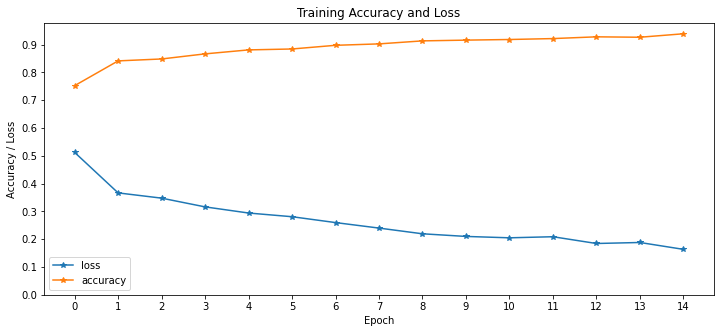

In [15]:
plt.figure(figsize=(12,5))
plt.plot(history.history['loss'], marker='*', label='loss')
plt.plot(history.history['accuracy'], marker='*', label='accuracy')
plt.title('Training Accuracy and Loss')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.xticks(np.arange(0, int(epochs)))
plt.ylabel('Accuracy / Loss')
plt.yticks(np.arange(0,1, step=0.1))
plt.show()

The next two graphs compare the accuracy and loss of the train and validation sets. The accuracy is increasing and the loss is decreasing as expected. The true value of these graphs is that they allow us to see whether or not the model is over fitting. This is shown when the validation and train metrics heavily diverge, typically near the end third of the process. The closeness of the lines indicate that the model is not overfitting and performing well. That being said, there is an anomaly with this output. The validation accuracy is typically lower than that of the training data and the loss is typically higher. Through [online research](https://www.researchgate.net/post/When_can_Validation_Accuracy_be_greater_than_Training_Accuracy_for_Deep_Learning_Models) it looks like the high number of dropouts maybe causing this but it could also be due to a slight class imbalance since there are roughly 200 more images in the "no" class. Further testing is required to pinpoint the cause but it is unlikely that it is invalidating the performance of the model.

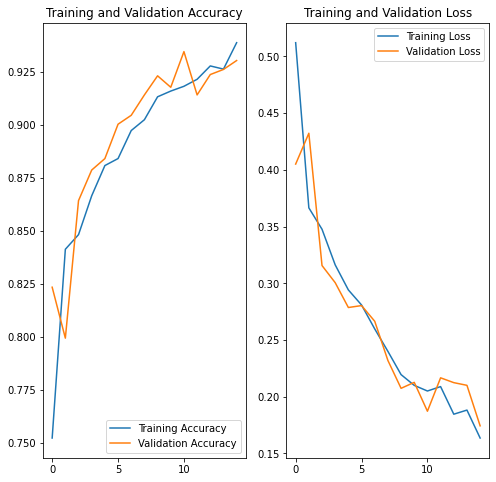

In [16]:
trainAccuracyCNNModel = history.history['accuracy']
valAccuracyCNNModel = history.history['val_accuracy']

trainLossCNNModel = history.history['loss']
valLossCNNModel = history.history['val_loss']

epochs_range = range(0,int(epochs))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, trainAccuracyCNNModel, label='Training Accuracy')
plt.plot(epochs_range, valAccuracyCNNModel, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, trainLossCNNModel, label='Training Loss')
plt.plot(epochs_range, valLossCNNModel, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


This matrix displays the performance of of this iteration of the model. Of the 439 test images 411 were classified correctly (93.6%). It was slightly better at predicting the images with masks (96.7%) than it was at predicting the images without masks (90.6%). There is a 4.8% false positive rate which would be the most problematic error in real life.

In [20]:
# Runs test images through the model and outputs matrix
yesDir = 'test_rand/yes'
noDir = 'test_rand/no'
# the a, b, c, d variables are just here to stop an annoying useless print statement
a, b, c, d = predictData(yesDir, noDir)

Found 215 images belonging to 1 classes.
Found 224 images belonging to 1 classes.


,predicted no,predicted yes
true yes,1,214
true no,222,2


### Demonstation and Process Speed Testing

If this model were to be applied to raw video it would have to run fast enough to handle the large amount of frames (images) output by that video. High quality films and television are typically filmed at 60 frames per second (fps) but other forms of video like CCTV or other security cameras would run at a much lower frame rate. For facial recognition purposes it is necessary to film at [30 fps](https://ipvm.com/reports/frame-rate-surveillance-guide). The tests below show that it roughly takes 29ms to predict the image or frame. This speed would support video up to 34 fps and therefore can implemented on raw video for prediction purposes. 

1/1 [==============================] - 0s 117ms/step


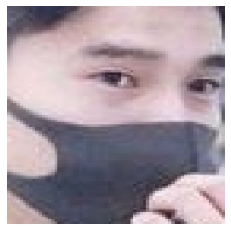

with_mask_892.jpg
There is a 99.87% chance
this person is wearing a mask.

1/1 [==============================] - 0s 28ms/step


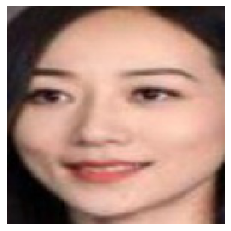

without_mask_879.jpg
There is a 100.0% chance
this person is NOT wearing a mask.


In [21]:
# Randomly tests 2 images, 1 from each class
yesDir = 'test_rand/yes/images/'
noDir = 'test_rand/no/images/'
imagePredictTest(yesDir, noDir)

### Iteration

This for loop has been written to truly test the predictive accuracy of this model through iteration. Using the functions that were outlined earlier in the notebook this loop run the entire implementation process a number of times with different train, validation, and test sets ensuring that the model isn't receiving a relatively easy batch to learn from or test with. It then agglomerates those results into a final matrix for evaluation.

In [19]:
# number of iterations to run
iterations = 5
#number of epochs per iteration
epochs = 15

#empty array to append individual iteration results into
iterTestTrueYes = []
iterTestPredYes = []
iterTestTrueNo = []
iterTestPredNo = []

# directories
srcDirYes = 'yes/'
srcDirNo = 'no/'
trainDirYes = 'mask_detection_random/yes'
testDirYesMove = 'test_rand/yes/images'
testDirYes = 'test_rand/yes/'
trainDirNo = 'mask_detection_random/no'
testDirNoMove = 'test_rand/no/images'
testDirNo = 'test_rand/no/'
splitFrac = 0.95
srcDir = 'mask_detection_random/'
testDir = 'test_rand/'

# Loops through randomMove, split, cnnModel, predictData functions for the number of iterations
for i in range(iterations):
    print('###########################################################')
    
    print()
    print(f"Start of Iteration {i+1}/{iterations}")
    # Iteration start time
    t = time.localtime()
    current_time = time.strftime("%H:%M:%S", t)
    print(current_time)
    print()
    
    # Randomly moves files
    randomMove(srcDirYes, trainDirYes, testDirYesMove, splitFrac)
    randomMove(srcDirNo, trainDirNo, testDirNoMove, splitFrac)
    print()
    
    # Train validation split
    maskTrain, maskVal = split(srcDir)
    print()
    
    print(f"Started model iteration {i+1}/{iterations}")
    # Compile and fit model
    history = cnnModel(maskTrain, maskVal, epochs, 0)
    print(f"Completed model iteration {i+1}/{iterations}")
    print()
    
    # predicts the test data on the trained model
    test_trueYes, test_trueNo, test_predYes, test_predNo = predictData(testDirYes, testDirNo)
    
    # Concatenate the test results for the iteration into the empty array
    iterTestTrueYes = np.concatenate((iterTestTrueYes, test_trueYes))
    iterTestPredYes = np.concatenate((iterTestPredYes, test_predYes))
    iterTestTrueNo = np.concatenate((iterTestTrueNo, test_trueNo))
    iterTestPredNo = np.concatenate((iterTestPredNo, test_predNo))
    print()
    
    print(f"End of Iteration {i+1}/{iterations}")
    print()
    

print()
print('###########################################################')
print()
print("Total Prediction Matrix:")
# Creates a matrix using all the results from the iteration arrays

# Creates a confusion matrix for the yes data
iterMatrixYes = pd.DataFrame(confusion_matrix(iterTestTrueYes, iterTestPredYes),
            index = ['true yes',''],
            columns =  ['predicted no','predicted yes'])
# Grabs the first row of the matrix
iterMatrixYes = iterMatrixYes[0:1]

# Creates a confusion matrix for the yes data
iterMatrixNo = pd.DataFrame(confusion_matrix(iterTestTrueNo, iterTestPredNo),
            index = ['true no',''],
            columns =  ['predicted no','predicted yes'])
# Grabs the first row of the matrix
iterMatrixNo = iterMatrixNo[0:1]

# Combines the rows from the yes and no matrices
itermatrix = pd.concat([iterMatrixYes,iterMatrixNo])
display(itermatrix)
print('###########################################################')

###########################################################

Start of Iteration 1/5
14:42:47

Final number of images in mask_detection_random/yes: 4080
Final number of images in test_rand/yes/images: 215
Final number of images in mask_detection_random/no: 4241
Final number of images in test_rand/no/images: 224

Found 8321 files belonging to 2 classes.
Using 6657 files for training.
Found 8321 files belonging to 2 classes.
Using 1664 files for validation.

Started model iteration 1/5
Completed model iteration 1/5

Found 215 images belonging to 1 classes.
Found 224 images belonging to 1 classes.


,predicted no,predicted yes
true yes,6,209
true no,207,17



End of Iteration 1/5

###########################################################

Start of Iteration 2/5
17:00:17

Final number of images in mask_detection_random/yes: 4080
Final number of images in test_rand/yes/images: 215
Final number of images in mask_detection_random/no: 4241
Final number of images in test_rand/no/images: 224

Found 8321 files belonging to 2 classes.
Using 6657 files for training.
Found 8321 files belonging to 2 classes.
Using 1664 files for validation.

Started model iteration 2/5
Completed model iteration 2/5

Found 215 images belonging to 1 classes.
Found 224 images belonging to 1 classes.


,predicted no,predicted yes
true yes,11,204
true no,216,8



End of Iteration 2/5

###########################################################

Start of Iteration 3/5
19:27:49

Final number of images in mask_detection_random/yes: 4080
Final number of images in test_rand/yes/images: 215
Final number of images in mask_detection_random/no: 4241
Final number of images in test_rand/no/images: 224

Found 8321 files belonging to 2 classes.
Using 6657 files for training.
Found 8321 files belonging to 2 classes.
Using 1664 files for validation.

Started model iteration 3/5
Completed model iteration 3/5

Found 215 images belonging to 1 classes.
Found 224 images belonging to 1 classes.


,predicted no,predicted yes
true yes,4,211
true no,223,1



End of Iteration 3/5

###########################################################

Start of Iteration 4/5
22:01:58

Final number of images in mask_detection_random/yes: 4080
Final number of images in test_rand/yes/images: 215
Final number of images in mask_detection_random/no: 4241
Final number of images in test_rand/no/images: 224

Found 8321 files belonging to 2 classes.
Using 6657 files for training.
Found 8321 files belonging to 2 classes.
Using 1664 files for validation.

Started model iteration 4/5
Completed model iteration 4/5

Found 215 images belonging to 1 classes.
Found 224 images belonging to 1 classes.


,predicted no,predicted yes
true yes,7,208
true no,220,4



End of Iteration 4/5

###########################################################

Start of Iteration 5/5
00:15:32

Final number of images in mask_detection_random/yes: 4080
Final number of images in test_rand/yes/images: 215
Final number of images in mask_detection_random/no: 4241
Final number of images in test_rand/no/images: 224

Found 8321 files belonging to 2 classes.
Using 6657 files for training.
Found 8321 files belonging to 2 classes.
Using 1664 files for validation.

Started model iteration 5/5
Completed model iteration 5/5

Found 215 images belonging to 1 classes.
Found 224 images belonging to 1 classes.


,predicted no,predicted yes
true yes,1,214
true no,222,2



End of Iteration 5/5


###########################################################

Total Prediction Matrix:


,predicted no,predicted yes
true yes,29,1046
true no,1088,32


###########################################################


### Next Steps

The next steps for this project are to investigate the class imbalance to see if it is effecting the validation performance and the results. Testing with less dropouts in the model architecture is something else to be tested. A function to isolate the wrongly classified images should also be written so that they can be inspected for common factors. Finally applying this model to raw video is the ultimate goal and would make it applicable to real world issues.